In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
plt.style.use('seaborn')


# Arima model
source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [2]:
path = open('document.txt', 'r').read().strip()
os.listdir(f'{path}')

df_arima = pd.DataFrame([])
for year in range(2015,2020):
    df_data = pd.read_feather(f"{path}/{year}_street.feather")
    filter = df_data['Falls within'].str.contains('South Wales')
    df_data = df_data[filter]
    df_data = df_data[df_data['Crime type']=='Violence and sexual offences']
    df_data = df_data['Month'].value_counts().sort_index()
    df_arima = pd.concat([df_arima, df_data])
    del df_data



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

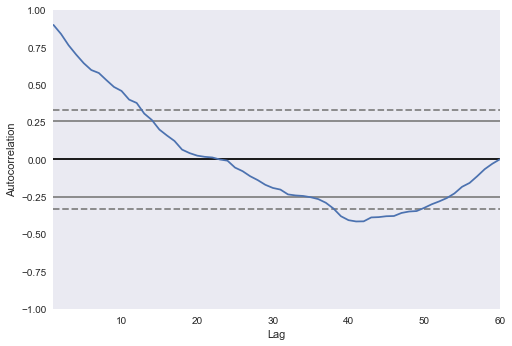

In [3]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_arima)

In [4]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_arima, order=(8,1,0));
model_fit = model.fit();
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   60
Model:                 ARIMA(8, 1, 0)   Log Likelihood                -385.718
Date:                Sun, 03 Apr 2022   AIC                            789.435
Time:                        19:43:46   BIC                            808.133
Sample:                    01-01-2015   HQIC                           796.734
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3751      0.131     -2.872      0.004      -0.631      -0.119
ar.L2          0.0698      0.146      0.478      0.633      -0.217       0.356
ar.L3         -0.0928      0.155     -0.599      0.5

C:\Users\Arcane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Arcane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Arcane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


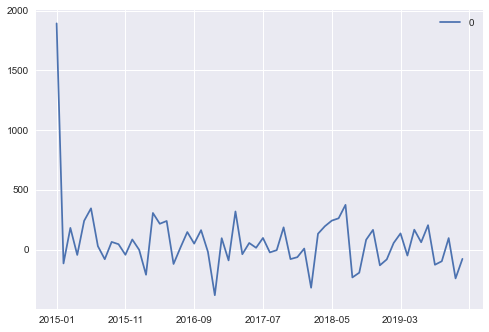

In [5]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot();

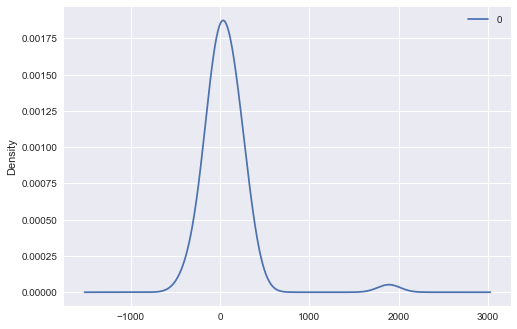

In [6]:
residuals.plot(kind='kde');

In [7]:
print(residuals.describe())

                 0
count    60.000000
mean     67.909248
std     289.702708
min    -382.105332
25%     -78.535163
50%      47.210052
75%     165.026006
max    1892.000000


48 12
predicted=3460.223718, expected=3311.000000
predicted=3401.954053, expected=3542.000000
predicted=3488.840453, expected=3687.000000
predicted=3549.745291, expected=3455.000000
predicted=3478.849859, expected=3647.000000
predicted=3615.830643, expected=3708.000000
predicted=3691.079388, expected=3906.000000
predicted=3711.250049, expected=3550.000000
predicted=3726.060261, expected=3625.000000
predicted=3671.543915, expected=3790.000000
predicted=3739.615146, expected=3470.000000
predicted=3524.924496, expected=3435.000000
Test MSE: 25342.528
Test RMSE: 159.193
Test MAE: 149.810


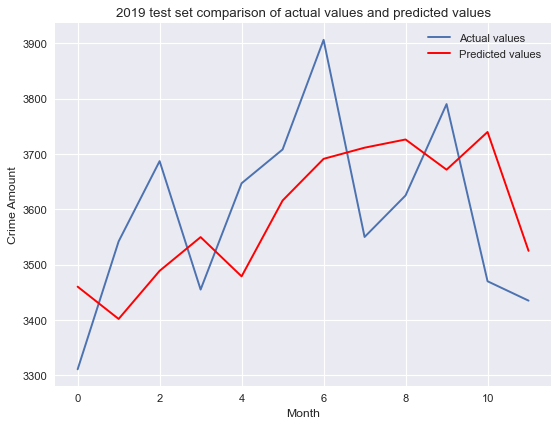

In [8]:
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
# df_arima.index = df_arima.index.to_period('M')

# split into train and test sets
X = df_arima.values
#first 4 years training and 2019 as test data
train, test = X[0:48], X[48:len(X)]
print(len(train), len(test))
history = [x for x in train]
predictions = list()
sum = 0
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(8,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	sum += abs(obs - yhat)
	print('predicted=%f, expected=%f' % (yhat, obs))
 
# evaluate forecasts
mae = sum/len(test)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['Actual values', 'Predicted values'])
plt.title('2019 test set comparison of actual values and predicted values')
plt.xlabel('Month')
plt.ylabel('Crime Amount')
plt.show()